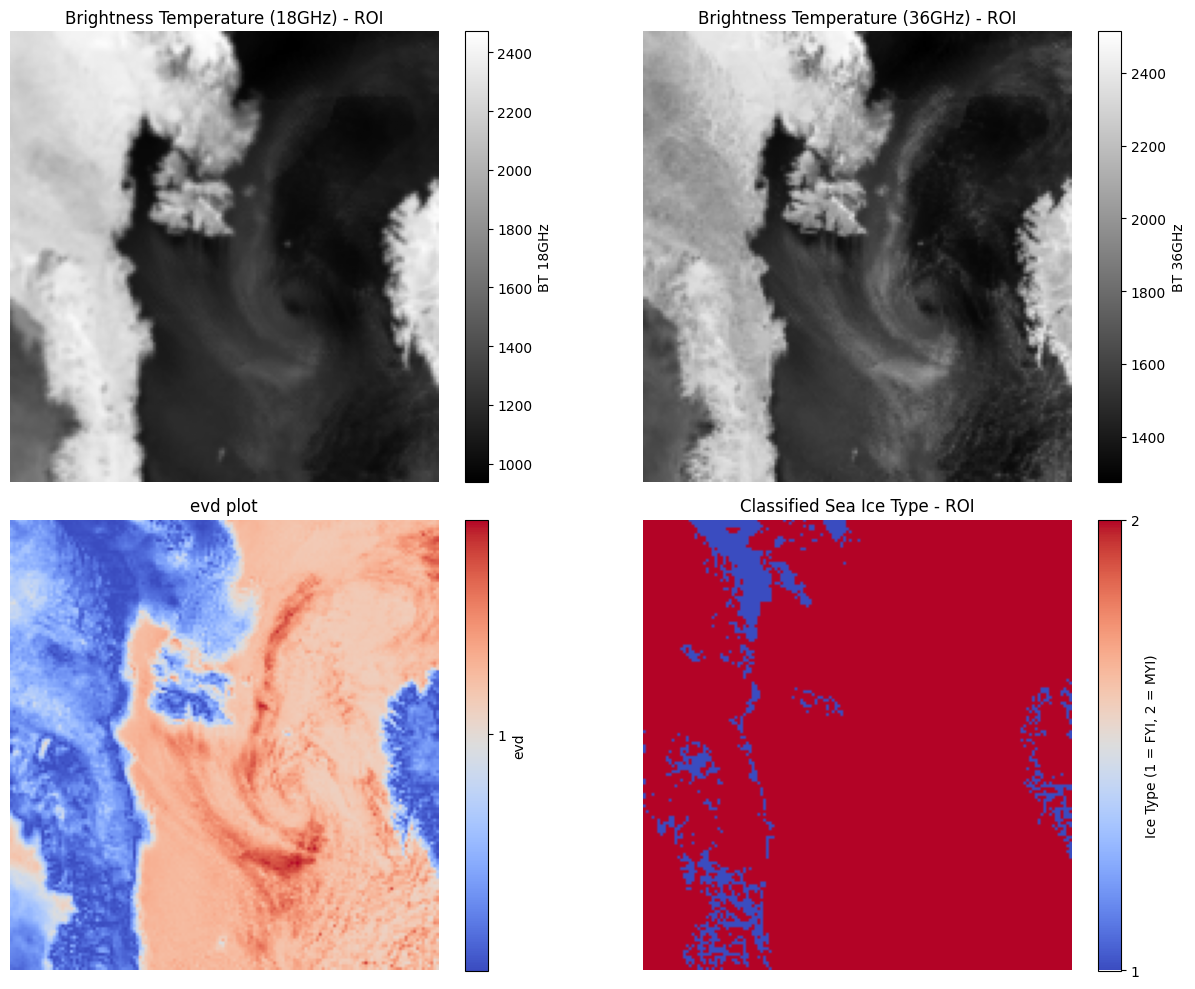

In [23]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Define coordinate bounds
lat_min, lat_max = 70.0, 85.0  # Near the North Pole
lon_min, lon_max = -10.0, 50.0  # Across the Arctic Ocean


file_path = '/content/DATA_3.he5'

with h5py.File(file_path, 'r') as f:
    grid_path = "HDFEOS/GRIDS/NpPolarGrid12km"
    lat = f[f"{grid_path}/lat"][:]
    lon = f[f"{grid_path}/lon"][:]
    bt_18 = f[f"{grid_path}/Data Fields/SI_12km_NH_18H_ASC"][:]
    bt_36 = f[f"{grid_path}/Data Fields/SI_12km_NH_36H_ASC"][:]

    # Get mask for desired region
    mask = (lat >= lat_min) & (lat <= lat_max) & (lon >= lon_min) & (lon <= lon_max)

    if not np.any(mask):
        raise ValueError("No data points fall within the specified region!")

    # Find bounding box of mask
    rows, cols = np.where(mask)
    row_min, row_max = rows.min(), rows.max()
    col_min, col_max = cols.min(), cols.max()

    # Crop arrays
    bt_18_crop = bt_18[row_min:row_max+1, col_min:col_max+1]
    bt_36_crop = bt_36[row_min:row_max+1, col_min:col_max+1]
    lat_crop = lat[row_min:row_max+1, col_min:col_max+1]
    lon_crop = lon[row_min:row_max+1, col_min:col_max+1]

    # Compute EVD and classify ice type
    evd = abs(bt_18_crop - bt_36_crop)/288
    ice_type = np.where(evd>0.1, 2, 1)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: BT 18GHz
im1 = axs[0, 0].imshow(bt_18_crop, cmap='gray')
axs[0, 0].set_title('Brightness Temperature (18GHz) - ROI')
axs[0, 0].axis('off')
fig.colorbar(im1, ax=axs[0, 0], fraction=0.046, pad=0.04, label='BT 18GHz')

# Plot 2: BT 36GHz
im2 = axs[0, 1].imshow(bt_36_crop, cmap='gray')
axs[0, 1].set_title('Brightness Temperature (36GHz) - ROI')
axs[0, 1].axis('off')
fig.colorbar(im2, ax=axs[0, 1], fraction=0.046, pad=0.04, label='BT 36GHz')

# Plot 3: EVD
im3 = axs[1, 0].imshow(evd, cmap='coolwarm')
axs[1, 0].set_title('evd plot')
axs[1, 0].axis('off')
fig.colorbar(im3, ax=axs[1, 0], fraction=0.046, pad=0.04, ticks=[1, 2], label='evd')

# Plot 4: Ice Type
im4 = axs[1, 1].imshow(ice_type, cmap='coolwarm', vmin=1, vmax=2)
axs[1, 1].set_title('Classified Sea Ice Type - ROI')
axs[1, 1].axis('off')
fig.colorbar(im4, ax=axs[1, 1], fraction=0.046, pad=0.04, ticks=[1, 2], label='Ice Type (1 = FYI, 2 = MYI)')

plt.tight_layout()
plt.show()



In [24]:
fyi_count = np.sum(ice_type == 1)
myi_count = np.sum(ice_type == 2)
total = fyi_count + myi_count

print(f"First-Year Ice (FYI): {fyi_count} pixels ({(fyi_count/total)*100:.2f}%)")
print(f"Multi-Year Ice (MYI): {myi_count} pixels ({(myi_count/total)*100:.2f}%)")

First-Year Ice (FYI): 1759 pixels (7.42%)
Multi-Year Ice (MYI): 21941 pixels (92.58%)


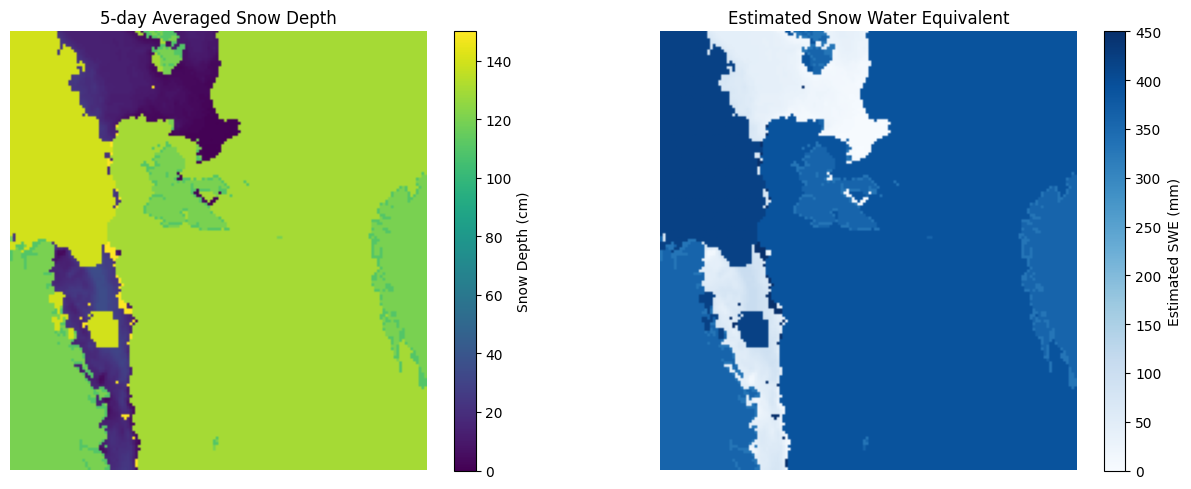

In [28]:
with h5py.File(file_path, 'r') as f:
    grid_path = "HDFEOS/GRIDS/NpPolarGrid12km"

    # Load variables
    lat = f[f"{grid_path}/lat"][:]
    lon = f[f"{grid_path}/lon"][:]
    snow_depth = f[f"{grid_path}/Data Fields/SI_12km_NH_SNOWDEPTH_5DAY"][:]  # cm or m — depends on metadata

    # Mask for region
    mask = (lat >= lat_min) & (lat <= lat_max) & (lon >= lon_min) & (lon <= lon_max)
    if not np.any(mask):
        raise ValueError("No data points in the specified region!")

    # Crop
    rows, cols = np.where(mask)
    rmin, rmax = rows.min(), rows.max()
    cmin, cmax = cols.min(), cols.max()

    snow_crop = snow_depth[rmin:rmax+1, cmin:cmax+1]
    lat_crop = lat[rmin:rmax+1, cmin:cmax+1]
    lon_crop = lon[rmin:rmax+1, cmin:cmax+1]

    # Handle fill values if any (e.g., 9999)
    snow_crop = np.where(snow_crop > 1000, np.nan, snow_crop)

    # Convert depth to meters if needed
    snow_m = snow_crop / 100.0  # assuming original is in cm

    # Estimate SWE (Snow Water Equivalent)
    density = 300  # kg/m³ for sea ice snow
    swe = snow_m * density  # SWE in kg/m² = mm water equivalent



# Plot snow depth
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

im5 = axs[0].imshow(snow_crop, cmap='viridis')
axs[0].set_title('5-day Averaged Snow Depth')
axs[0].axis('off')
fig.colorbar(im5, ax=axs[0], fraction=0.046, pad=0.04, label='Snow Depth (cm)')

im6 = axs[1].imshow(swe, cmap='Blues')
axs[1].set_title('Estimated Snow Water Equivalent')
axs[1].axis('off')
fig.colorbar(im6, ax=axs[1], fraction=0.046, pad=0.04, label='Estimated SWE (mm)')

plt.tight_layout()
plt.show()